# Bayesian Linear Regression in Python via PyMC3

- https://towardsdatascience.com/bayesian-linear-regression-in-python-via-pymc3-ab8c2c498211 

<br>

***

<br>

## Problems w/Linear Regression
- Single prediction output
    - We're not certain if the coefficient mean is the proper prediction no matter what
    - Solution is to Bootstrap - subsample your data and fit the model on this subsample and use it to make a prediction. Repeat 1000x until you obtain 1000 different predictions.

In [15]:
import pymc3 as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

In [5]:
pm.__version__

'3.11.5'

In [6]:
# Dataset
x = [
   -1.64934805,  0.52925273,  1.10100092,  0.38566793, -1.56768245,
    1.26195686,  0.92613986, -0.23942803,  0.33933045,  1.14390657,
    0.65466195, -1.36229805, -0.32393554, -0.23258941,  0.17688024,
    1.60774334, -0.22801156,  1.53008133, -1.31431042, -0.27699609
] # inputs
y = [
   -3.67385666,  3.37543275,  6.25390538,  1.41569973, -2.08413872,
    6.71560158,  6.32344159,  2.40651236,  4.54217349,  6.25778739,
    4.98933806, -2.69713137,  1.45705571, -0.49772953,  1.50502898,
    7.27228263,  1.6267433 ,  6.43580518, -0.50291509,  0.65674682
] # outputs

In [7]:
%%time
with pm.Model() as model:
    
    ### define priors 
    # normal dist for the slope
    a = pm.Normal('slope', 0, 16)
    # normal dist for the intecept
    b = pm.Normal('intercept', 0, 16)
    # exponential dist for the error
    s = pm.Exponential('error', 1)
    
    # predictions - notice the regression formula
    obs = pm.Normal('observation', a*x + b, s, observed=y)
    
    # use MCMC to sample
    trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 183 seconds.


CPU times: total: 15.7 s
Wall time: 22min 10s


array([<AxesSubplot:title={'center':'slope'}>,
       <AxesSubplot:title={'center':'intercept'}>,
       <AxesSubplot:title={'center':'error'}>], dtype=object)

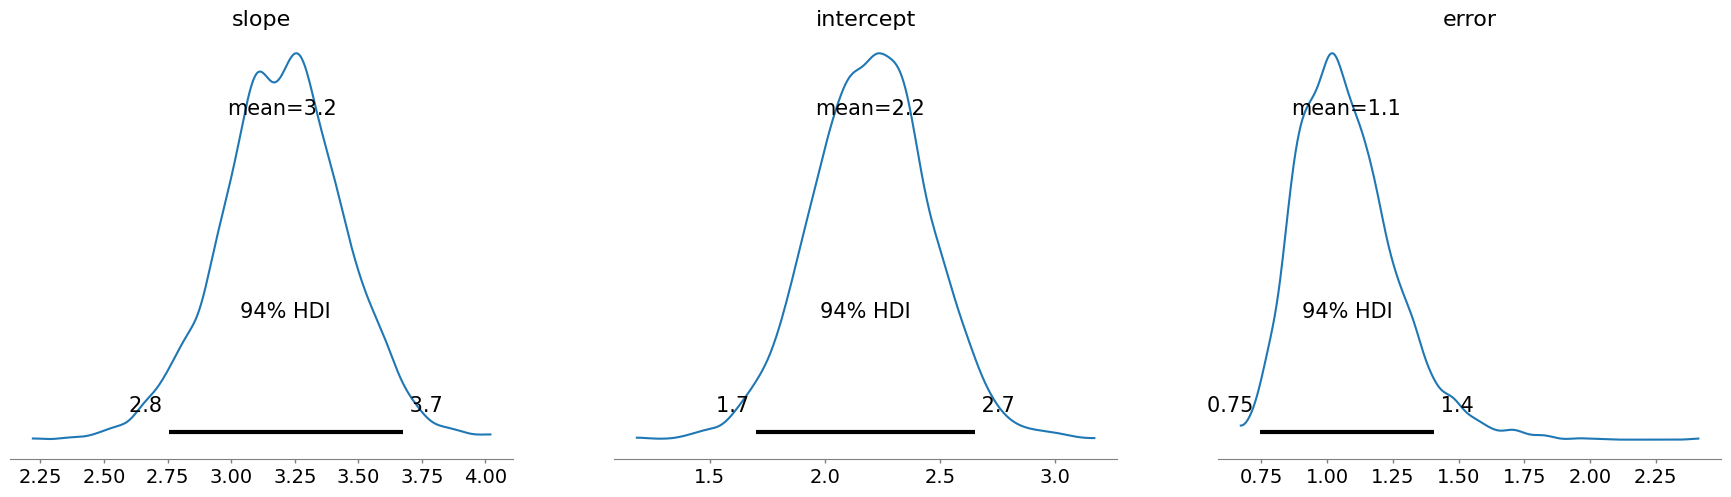

In [8]:
az.plot_posterior(trace)

- Same results as frequentist linear regression (slope = 3.2, intercept = 2.2, error = 1.1)
- notice the credible intervals!
    - with a probability of 94%, the slope a is between 2.7 & 3.7

## Predictions!

In [9]:
%%time
with pm.Model() as predictive_model:
    a = pm.Normal('slope', 0, 16)
    b = pm.Normal('intercept', 0, 16)
    s = pm.Exponential('error', 1)
    
    x_ = pm.Data('features', x) # a data container, can be changed
    
    obs = pm.Normal('observation', a*x_ + b, s, observed=y)
    
    trace = pm.sample()

C:\Users\a1274500\Anaconda3\envs\pym3env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [error, intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 173 seconds.


CPU times: total: 11 s
Wall time: 2min 57s


In [10]:
# New dataset for creating predictions
x_new = np.linspace(-3, 3, 50) # 50 input values between -3 and 3

In [11]:
# Open back up predictive model to score new data
with predictive_model:
    pm.set_data({'features': x_new})
    posterior = pm.sample_posterior_predictive(trace) #dictionary that containts new observations

In [13]:
y_pred = posterior["observation"]

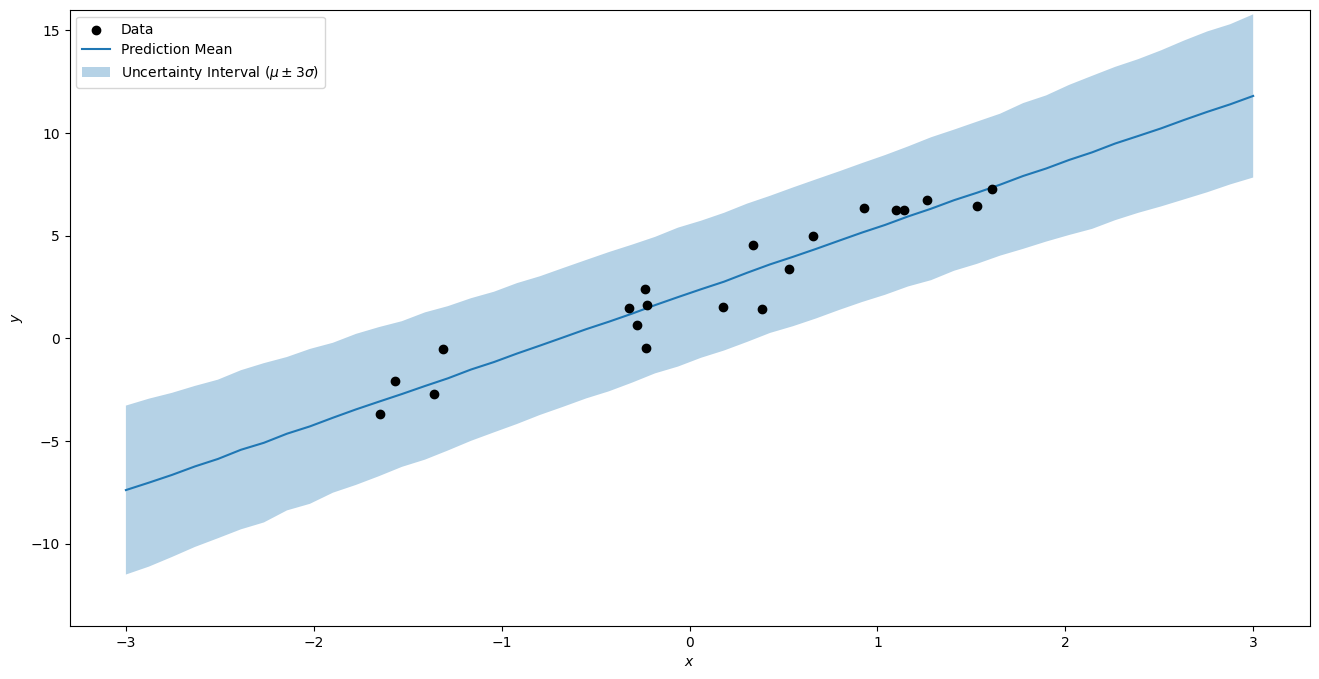

In [16]:
y_mean = y_pred.mean(axis=0)
y_std = y_pred.std(axis=0)
plt.figure(figsize=(16, 8))
plt.scatter(x, y, c='k', zorder=10, label='Data')
plt.plot(x_new, y_mean, label='Prediction Mean')
plt.fill_between(x_new, y_mean - 3*y_std, y_mean + 3*y_std, alpha=0.33, label='Uncertainty Interval ($\mu\pm3\sigma$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.ylim(-14, 16)
plt.legend(loc='upper left')

***
***
***